# Covariate Analysis
Notebook to demonstrate the different distributions of New York and Alabama Census data.

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
import pickle
import optuna

In [3]:
new_york = pd.read_csv('nys_cleaned.csv')

In [5]:
alabama = pd.read_csv('Alabama_test.csv')
alabama

,AGEP,CIT,DEYE,MAR,SEX,ANC,NATIVITY,RACAIAN,RACASN,RACBLK,...,NP,TYPE,FINCP,HINCP,RACES,MIL_STAT,INDUSTRY,SOCP_recat,MAR_YEARS,AGE_cat
0,19,1,2,Never Married,Female,1,1,0,0,0,...,1,3,0.0,0.0,White,Served,Retail,SAL,0.0,Under 40
1,18,1,2,Never Married,Female,1,1,0,0,1,...,1,3,0.0,0.0,Black,Served,Entertainment,SAL,0.0,Under 40
2,53,1,2,Never Married,Male,2,1,0,0,0,...,1,2,0.0,0.0,White,Served,Administration,HLS,0.0,Between 40 and 64
3,28,1,2,Never Married,Male,1,1,0,0,0,...,1,2,0.0,0.0,White,Served,None,None,0.0,Under 40
4,25,1,2,Never Married,Female,1,1,0,0,0,...,1,2,0.0,0.0,White,Served,Manufacturing,TRN,0.0,Under 40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38497,93,1,1,Widowed,Female,4,1,0,0,0,...,2,1,126500.0,126500.0,White,Served,None,None,64.0,65 and over
38498,65,1,2,Never Married,Female,1,1,0,0,0,...,2,1,126500.0,126500.0,White,Served,Service,MGR,0.0,65 and over
38499,37,1,2,Separated,Female,1,1,0,0,0,...,5,1,33300.0,33300.0,White,Served,Entertainment,MGR,14.0,Under 40
38500,18,1,2,Never Married,Female,1,1,0,0,0,...,5,1,33300.0,33300.0,White,Served,Entertainment,EAT,0.0,Under 40


In [ ]:
sns.distplot(np.log1p(new_york.loc[new_york['PINCP'].gt(0)]['PINCP']), label = 'New York')
sns.distplot(np.log1p(alabama.loc[alabama['PINCP'].gt(0)]['PINCP']), label = 'Alabama')
plt.axvline(np.log1p(alabama.loc[alabama['PINCP'].gt(0)]['PINCP']).median(), color = 'r', linestyle = '--', label = 'Alabama median: {}'.format(alabama.loc[alabama['PINCP'].gt(0)]['PINCP'].median()))
plt.axvline(np.log1p(new_york.loc[new_york['PINCP'].gt(0)]['PINCP']).median(), color = 'blue', linestyle = '--', label = 'New York median: {}'.format(new_york.loc[new_york['PINCP'].gt(0)]['PINCP'].median()))
plt.legend(loc = 'upper left')
plt.xlabel('Income (Log Scale)', fontsize= 12)

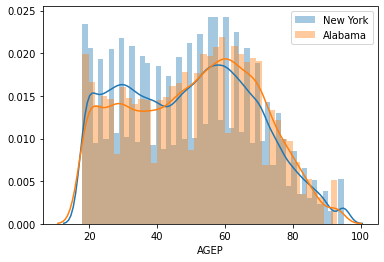

In [10]:
sns.distplot(new_york['AGEP'], label = 'New York')
sns.distplot(alabama['AGEP'], label = 'Alabama')
plt.legend();

In [ ]:
new_york

In [17]:
alabama['PINCP'] = alabama['PINCP'].fillna(0)

In [22]:
alabama['PINCP'].value_counts()

0.0         4236
30000.0      722
12000.0      624
50000.0      619
20000.0      604
            ... 
13390.0        1
398400.0       1
16020.0        1
145100.0       1
140900.0       1
Name: PINCP, Length: 2720, dtype: int64

In [30]:
alabama['PINCP'] = np.where(alabama['PINCP'].gt(0), alabama['PINCP'], 0)
new_york['PINCP'] = np.where(new_york['PINCP'].gt(0), new_york['PINCP'], 0)

In [31]:
np.log1p(alabama['PINCP'])

0         0.000000
1         7.378384
2         9.210440
3         0.000000
4         0.000000
           ...    
38497    10.878066
38498    11.205054
38499    10.214679
38500     8.699681
38501     0.000000
Name: PINCP, Length: 38502, dtype: float64

Text(0.5, 0, 'Income (Log Scale)')

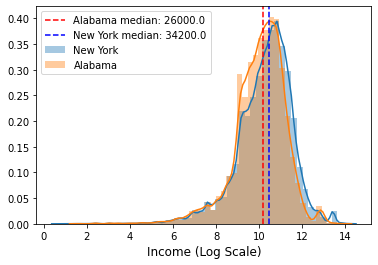

In [65]:
sns.distplot(np.log1p(new_york.loc[new_york['PINCP'].gt(0)]['PINCP']), label = 'New York')
sns.distplot(np.log1p(alabama.loc[alabama['PINCP'].gt(0)]['PINCP']), label = 'Alabama')
plt.axvline(np.log1p(alabama.loc[alabama['PINCP'].gt(0)]['PINCP']).median(), color = 'r', linestyle = '--', label = 'Alabama median: {}'.format(alabama.loc[alabama['PINCP'].gt(0)]['PINCP'].median()))
plt.axvline(np.log1p(new_york.loc[new_york['PINCP'].gt(0)]['PINCP']).median(), color = 'blue', linestyle = '--', label = 'New York median: {}'.format(new_york.loc[new_york['PINCP'].gt(0)]['PINCP'].median()))
plt.legend(loc = 'upper left')
plt.xlabel('Income (Log Scale)', fontsize= 12)

In [66]:
from scipy import stats

In [67]:
stats.ttest_ind(new_york.loc[new_york['PINCP'].gt(0)]['PINCP'], 
                alabama.loc[alabama['PINCP'].gt(0)]['PINCP'],
                equal_var = False)

Ttest_indResult(statistic=38.58532352834319, pvalue=0.0)

In [71]:

np.r_[[32, 4, 2,1]]


array([32,  4,  2,  1])

In [57]:
np.log1p(new_york.loc[new_york['PINCP'].gt(0)]['PINCP']).median()

10.440010162389305

In [58]:
np.log1p(alabama.loc[alabama['PINCP'].gt(0)]['PINCP']).median()

10.165890277802454

In [61]:
alabama.loc[alabama['PINCP'].gt(0)]['PINCP'].median()

26000.0

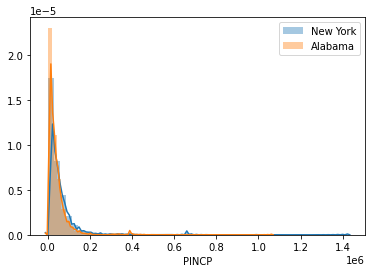

In [51]:
sns.distplot(new_york['PINCP'], label = 'New York')
sns.distplot(alabama['PINCP'], label = 'Alabama')
plt.legend();

### Preprocessing

In [6]:
NY_X = new_york.drop(columns=['HICOV'])
NY_y = new_york['HICOV']

continuous_columns = ['AGEP','INTP_cat','OIP_cat','RETP_cat','SEMP_cat','SSIP_cat','JWAP_mins','JWDP_mins','TOTAL_commute','JWMNP','PAP','SSP','WAGP','WKHP','OCCP','PERNP','PINCP',
                     'FINCP','HINCP','MAR_YEARS','NP']
categorical_columns = [x for x in NY_X.columns if x not in continuous_columns]

In [7]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(NY_X, NY_y, test_size=0.2, random_state=19)

#### One Hot Encoder (Categorical Features)

In [8]:
ohe = OneHotEncoder()
_X_train_ohe = ohe.fit_transform(X_train[categorical_columns]).toarray()
_X_train_ohe_df = pd.DataFrame(data = _X_train_ohe,
                        columns = ohe.get_feature_names(categorical_columns))

_X_test_ohe = ohe.transform(X_test[categorical_columns]).toarray()
_X_test_ohe_df = pd.DataFrame(data = _X_test_ohe,
                        columns = ohe.get_feature_names(categorical_columns))

#### Standard Scaler (Continuous Features)

In [9]:
scaler = StandardScaler()
_X_train_cont = scaler.fit_transform(X_train[continuous_columns])
_X_train_cont_df = pd.DataFrame(data = _X_train_cont,
                         columns = continuous_columns)

_X_test_cont = scaler.transform(X_test[continuous_columns])
_X_test_cont_df = pd.DataFrame(data = _X_test_cont,
                         columns = continuous_columns)

#### Merge Continuous Features with Categorical Features

In [10]:
_X_test_merged = _X_test_cont_df[continuous_columns].merge(_X_test_ohe_df, left_index=True, right_index=True)
_X_train_merged = _X_train_cont_df[continuous_columns].merge(_X_train_ohe_df, left_index=True, right_index=True)
_X_train_merged.shape

(127439, 468)

#### Oversampling with SMOTE

In [11]:
_smote = SMOTE(sampling_strategy='minority', random_state=42)
_X_train_merged, y_train = _smote.fit_sample(_X_train_merged, y_train)

In [12]:
_X_train_merged

,AGEP,INTP_cat,OIP_cat,RETP_cat,SEMP_cat,SSIP_cat,JWAP_mins,JWDP_mins,TOTAL_commute,JWMNP,...,SOCP_recat_OFF,SOCP_recat_PRD,SOCP_recat_PRS,SOCP_recat_PRT,SOCP_recat_SAL,SOCP_recat_SCI,SOCP_recat_TRN,AGE_cat_65 and over,AGE_cat_Between 40 and 64,AGE_cat_Under 40
0,1.069486,-0.125726,-0.134476,0.567740,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.000000
1,0.439742,0.760161,-0.134476,-0.244126,-0.112028,-0.168183,0.621716,0.686852,-0.377602,-1.150816,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000
2,0.649657,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000
3,0.124870,-0.125726,2.291511,-0.244126,-0.112028,-0.168183,0.719340,0.738130,0.167197,-0.976622,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000
4,-1.134618,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,2.020988,2.139725,-0.196002,-1.034687,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241989,-1.251834,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,-1.208881,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000
241990,0.072391,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000
241991,-0.976398,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,0.955384,1.034571,-0.347787,-1.112338,...,0.000000,0.0,0.0,0.0,0.164178,0.0,0.0,0.0,0.000000,1.000000
241992,-0.586746,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.071995,0.928005


In [13]:
alabama = pd.read_csv('Alabama_test.csv')
alabama

,AGEP,CIT,DEYE,MAR,SEX,ANC,NATIVITY,RACAIAN,RACASN,RACBLK,...,NP,TYPE,FINCP,HINCP,RACES,MIL_STAT,INDUSTRY,SOCP_recat,MAR_YEARS,AGE_cat
0,19,1,2,Never Married,Female,1,1,0,0,0,...,1,3,0.0,0.0,White,Served,Retail,SAL,0.0,Under 40
1,18,1,2,Never Married,Female,1,1,0,0,1,...,1,3,0.0,0.0,Black,Served,Entertainment,SAL,0.0,Under 40
2,53,1,2,Never Married,Male,2,1,0,0,0,...,1,2,0.0,0.0,White,Served,Administration,HLS,0.0,Between 40 and 64
3,28,1,2,Never Married,Male,1,1,0,0,0,...,1,2,0.0,0.0,White,Served,None,None,0.0,Under 40
4,25,1,2,Never Married,Female,1,1,0,0,0,...,1,2,0.0,0.0,White,Served,Manufacturing,TRN,0.0,Under 40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38497,93,1,1,Widowed,Female,4,1,0,0,0,...,2,1,126500.0,126500.0,White,Served,None,None,64.0,65 and over
38498,65,1,2,Never Married,Female,1,1,0,0,0,...,2,1,126500.0,126500.0,White,Served,Service,MGR,0.0,65 and over
38499,37,1,2,Separated,Female,1,1,0,0,0,...,5,1,33300.0,33300.0,White,Served,Entertainment,MGR,14.0,Under 40
38500,18,1,2,Never Married,Female,1,1,0,0,0,...,5,1,33300.0,33300.0,White,Served,Entertainment,EAT,0.0,Under 40


In [14]:
alabama_X = alabama.drop(columns=['HICOV'])
alabama_y = alabama['HICOV']

AL_cont_columns = ['AGEP','INTP_cat','OIP_cat','RETP_cat','SEMP_cat','SSIP_cat','JWAP_mins','JWDP_mins','TOTAL_commute','JWMNP','PAP','SSP','WAGP','WKHP','OCCP','PERNP','PINCP',
                     'FINCP','HINCP','MAR_YEARS','NP']
AL_cat_columns = [x for x in alabama_X.columns if x not in continuous_columns]

In [15]:

alabama_X_ohe = ohe.transform(alabama_X[categorical_columns]).toarray()
alabama_X_ohe_df = pd.DataFrame(data = alabama_X_ohe,
                        columns = ohe.get_feature_names(categorical_columns))


In [16]:
alabama_X_ohe_df

,CIT_1,CIT_2,CIT_3,CIT_4,CIT_5,DEYE_1,DEYE_2,MAR_Divorced,MAR_Married,MAR_Never Married,...,SOCP_recat_OFF,SOCP_recat_PRD,SOCP_recat_PRS,SOCP_recat_PRT,SOCP_recat_SAL,SOCP_recat_SCI,SOCP_recat_TRN,AGE_cat_65 and over,AGE_cat_Between 40 and 64,AGE_cat_Under 40
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38497,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
38498,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
38499,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38500,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
# alabama_scaler = StandardScaler()
alabama_X_cont = scaler.transform(alabama_X[continuous_columns])
alabama_X_cont_df = pd.DataFrame(data = alabama_X_cont,
                         columns = continuous_columns)


In [18]:
alabama_X_merged = alabama_X_cont_df[continuous_columns].merge(alabama_X_ohe_df, left_index=True, right_index=True)
alabama_X_merged

,AGEP,INTP_cat,OIP_cat,RETP_cat,SEMP_cat,SSIP_cat,JWAP_mins,JWDP_mins,TOTAL_commute,JWMNP,...,SOCP_recat_OFF,SOCP_recat_PRD,SOCP_recat_PRS,SOCP_recat_PRT,SOCP_recat_SAL,SOCP_recat_SCI,SOCP_recat_TRN,AGE_cat_65 and over,AGE_cat_Between 40 and 64,AGE_cat_Under 40
0,-1.606926,-0.192168,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-1.659405,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.177349,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.134618,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.292054,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38497,2.276496,-0.125726,-0.134476,2.639138,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
38498,0.807093,0.051451,-0.134476,0.780191,0.149320,-0.168183,0.572905,0.635574,-0.377602,-1.115978,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
38499,-0.662310,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,0.556634,0.481741,1.075196,-0.686299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38500,-1.659405,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,2.606730,2.755060,-0.196002,-1.034687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
alabama_smote = SMOTE(sampling_strategy='minority', random_state=42)
alabama_X_merged, alabama_y = alabama_smote.fit_sample(alabama_X_merged, alabama_y)

In [20]:
alabama_X_merged

,AGEP,INTP_cat,OIP_cat,RETP_cat,SEMP_cat,SSIP_cat,JWAP_mins,JWDP_mins,TOTAL_commute,JWMNP,...,SOCP_recat_OFF,SOCP_recat_PRD,SOCP_recat_PRS,SOCP_recat_PRT,SOCP_recat_SAL,SOCP_recat_SCI,SOCP_recat_TRN,AGE_cat_65 and over,AGE_cat_Between 40 and 64,AGE_cat_Under 40
0,-1.606926,-0.192168,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-1.659405,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.177349,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.134618,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.292054,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68793,-0.797758,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,0.394186,0.362363,0.530397,-0.860493,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
68794,0.685719,-0.169339,1.882627,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.343587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
68795,-0.209445,-0.125726,-0.134476,-0.244126,-0.083731,-0.168183,0.350325,0.221662,1.535727,-0.539049,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
68796,-1.181068,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
_X_train_merged

,AGEP,INTP_cat,OIP_cat,RETP_cat,SEMP_cat,SSIP_cat,JWAP_mins,JWDP_mins,TOTAL_commute,JWMNP,...,SOCP_recat_OFF,SOCP_recat_PRD,SOCP_recat_PRS,SOCP_recat_PRT,SOCP_recat_SAL,SOCP_recat_SCI,SOCP_recat_TRN,AGE_cat_65 and over,AGE_cat_Between 40 and 64,AGE_cat_Under 40
0,1.069486,-0.125726,-0.134476,0.567740,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.000000
1,0.439742,0.760161,-0.134476,-0.244126,-0.112028,-0.168183,0.621716,0.686852,-0.377602,-1.150816,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000
2,0.649657,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000
3,0.124870,-0.125726,2.291511,-0.244126,-0.112028,-0.168183,0.719340,0.738130,0.167197,-0.976622,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000
4,-1.134618,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,2.020988,2.139725,-0.196002,-1.034687,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241989,-1.251834,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,-1.208881,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000
241990,0.072391,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000
241991,-0.976398,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,0.955384,1.034571,-0.347787,-1.112338,...,0.000000,0.0,0.0,0.0,0.164178,0.0,0.0,0.0,0.000000,1.000000
241992,-0.586746,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.071995,0.928005


In [22]:
alabama_X_merged['class'] = 1
_X_train_merged['class'] = 0

In [23]:
NY_AL_merged = pd.concat([alabama_X_merged, _X_train_merged])
NY_AL_merged['class'].value_counts()

0    241994
1     68798
Name: class, dtype: int64

In [25]:
NY_AL_merged.reset_index(drop = True, inplace=True)

In [28]:
NY_AL_merged.to_csv('NY_AL_merged.csv', index= False ,header= True)

In [73]:
NY_AL_merged = pd.read_csv('NY_AL_merged.csv')

In [74]:
cov_X = NY_AL_merged.drop(columns = 'class')
cov_y = NY_AL_merged['class']

In [5]:
cov_smote = SMOTE(sampling_strategy='minority', random_state=42)
cov_X, cov_y = cov_smote.fit_sample(cov_X, cov_y)

In [75]:
cov_X

,AGEP,INTP_cat,OIP_cat,RETP_cat,SEMP_cat,SSIP_cat,JWAP_mins,JWDP_mins,TOTAL_commute,JWMNP,...,SOCP_recat_OFF,SOCP_recat_PRD,SOCP_recat_PRS,SOCP_recat_PRT,SOCP_recat_SAL,SOCP_recat_SCI,SOCP_recat_TRN,AGE_cat_65 and over,AGE_cat_Between 40 and 64,AGE_cat_Under 40
0,-1.606926,-0.192168,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,1.000000
1,-1.659405,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,1.000000
2,0.177349,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000
3,-1.134618,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000
4,-1.292054,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310787,-1.251834,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,-1.208881,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000
310788,0.072391,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000
310789,-0.976398,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,0.955384,1.034571,-0.347787,-1.112338,...,0.000000,0.0,0.0,0.0,0.164178,0.0,0.0,0.0,0.000000,1.000000
310790,-0.586746,-0.125726,-0.134476,-0.244126,-0.112028,-0.168183,-0.956532,-0.936947,-0.740801,1.125319,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.071995,0.928005


In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
log_reg = LogisticRegression()
log_reg.fit(cov_X, cov_y)

C:\Users\albert\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [80]:
_weights_array = NY_AL_merged.loc[NY_AL_merged['class'] == 0].drop(columns = 'class')

In [82]:
yhat = log_reg.decision_function(_weights_array)

In [84]:
yhat.shape

(241994,)

In [98]:
_C = 3
conditions = [
    yhat < -_C,
    yhat > _C
]
choices = [
    -3,
    3
]

yhat = np.select(conditions, choices, yhat)
yhat

array([-3.        , -3.        , -1.92667615, ..., -3.        ,
       -2.46129633, -2.25675817])

In [91]:
yhat.max()

9.97385908516613

In [92]:
yhat.min()

-35.690088687531016

In [89]:
np.exp(yhat)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [96]:
np.exp(-3)

0.049787068367863944

In [97]:
np.exp(3)

20.085536923187668

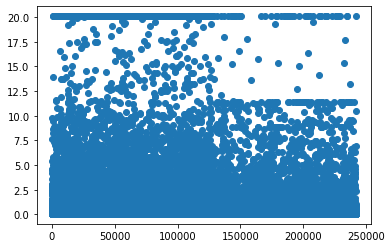

In [99]:
plt.scatter(range(len(yhat)), np.exp(yhat))

In [100]:
_ny_train = NY_AL_merged.loc[NY_AL_merged['class'] == 0].drop(columns = 'class')
_al_train = NY_AL_merged.loc[NY_AL_merged['class'] == 1].drop(columns = 'class')

In [ ]:
np.append(_ny_train, _al_train)

In [7]:
import tensorflow as tf


In [14]:
history_seq = tf.keras.layers.Input(cov_X.shape[1], )
x = history_seq
x = tf.keras.layers.Dense(100, activation = tf.keras.activations.swish)(x)
output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(history_seq, output)

model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])
              

In [ ]:
model.fit(cov_X, cov_y, epochs = 20)

Epoch 1/20


### Dummy Classifier

In [12]:
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(_X_train_merged, y_train)
dummy_train_pred = dummy_clf.predict(_X_train_merged)
dummy_pred = dummy_clf.predict(_X_test_merged)

print('Training Precision: ', precision_score(y_train, dummy_train_pred))
print('Testing Precision: ', precision_score(y_test, dummy_pred))
print('\n\n')
print('Training F1-Score: ', f1_score(y_train, dummy_train_pred))
print('Testing F1-Score: ', f1_score(y_test, dummy_pred))

Training Precision:  0.9494503252536508
Testing Precision:  0.9517576898932831



Training F1-Score:  0.9740697805471027
Testing F1-Score:  0.9752826335171992


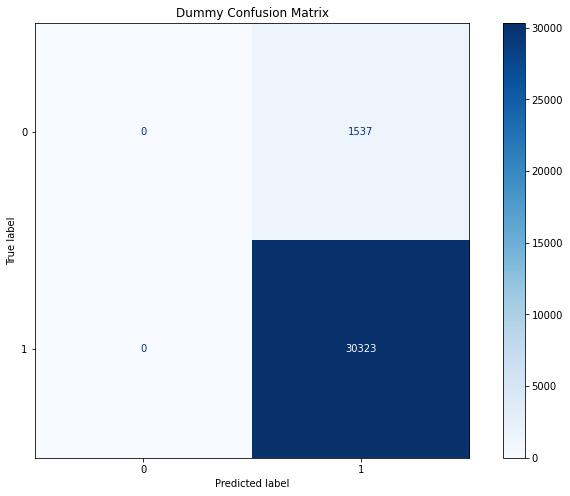

In [13]:
# plot confusion matrix
fig,ax = plt.subplots(figsize=(12,8))
plot_confusion_matrix(dummy_clf, _X_test_merged, y_test, cmap = 'Blues', values_format='d' , ax= ax)
ax.set_title('Dummy Confusion Matrix')
fig.savefig('Dummy_Confusion_Matrix');

### Logistic Regression

In [14]:
logreg_clf =LogisticRegression(solver='liblinear', penalty='l1')
logreg_clf.fit(_X_train_merged, y_train)
y_train_pred = logreg_clf.predict(_X_train_merged)
y_test_pred = logreg_clf.predict(_X_test_merged)


print('Training Precision: ', precision_score(y_train, y_train_pred))
print('Testing Precision: ', precision_score(y_test, y_test_pred))
print('\n\n')
print('Training F1-Score: ', f1_score(y_train, y_train_pred))
print('Testing F1-Score: ', f1_score(y_test, y_test_pred))

Training Precision:  0.9537255149953362
Testing Precision:  0.9559158134243458



Training F1-Score:  0.9749538389433664
Testing F1-Score:  0.9762938338147724


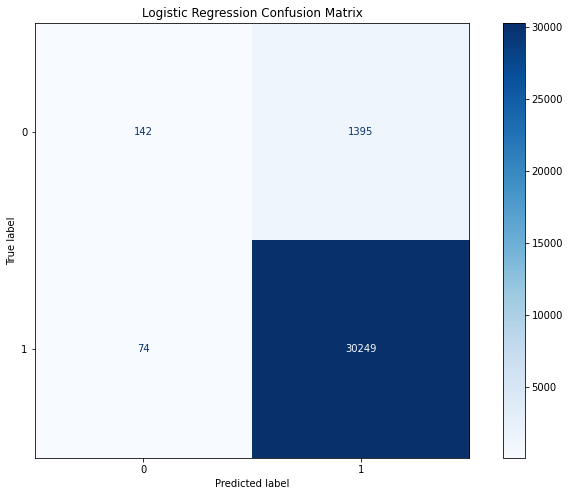

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
plot_confusion_matrix(logreg_clf, _X_test_merged, y_test, cmap = 'Blues', values_format='d' , ax= ax)
ax.set_title('Logistic Regression Confusion Matrix')
fig.savefig('Logistic_Regression_Confusion_Matrix');

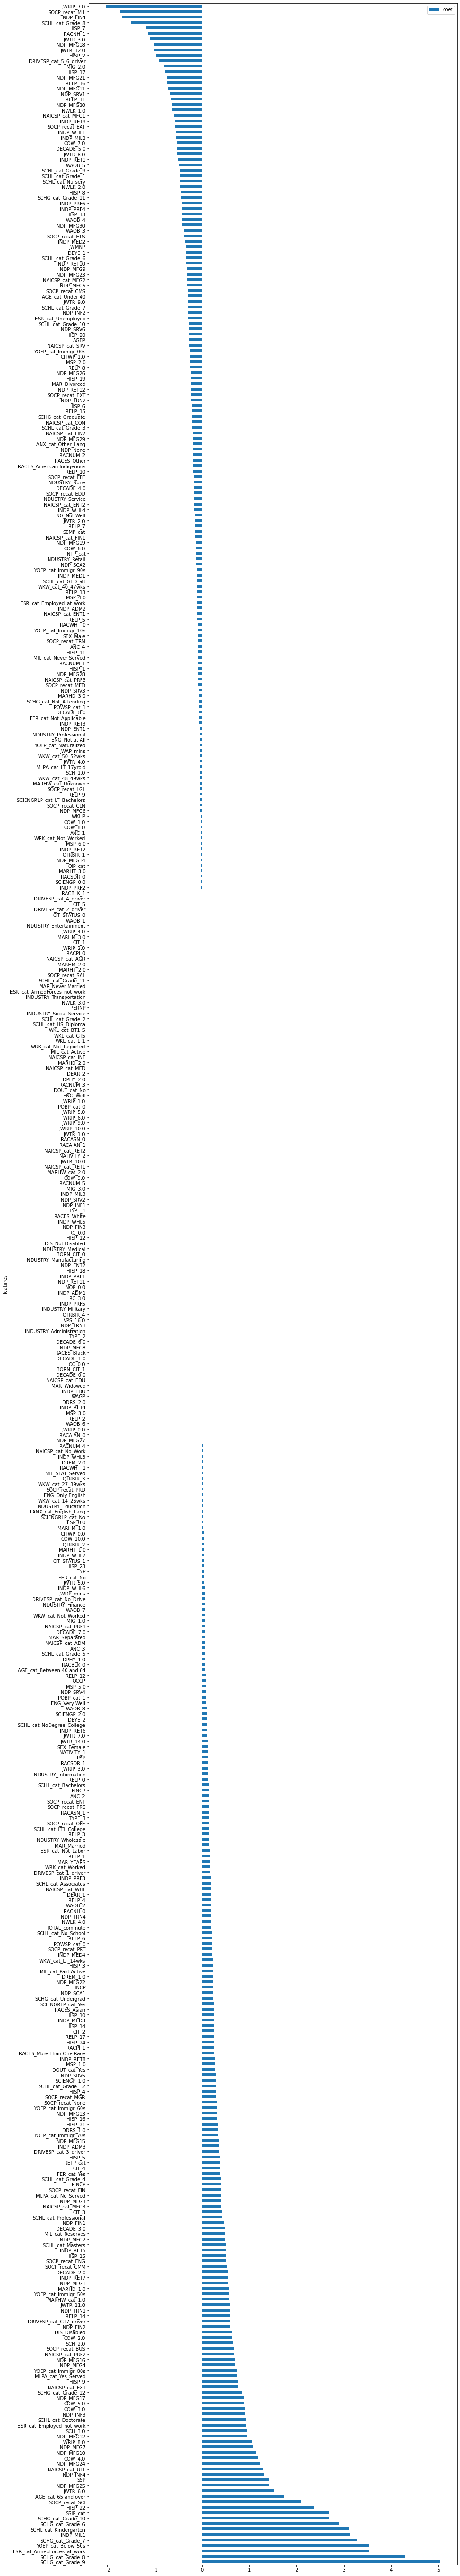

In [42]:
_coef_df = pd.DataFrame()
_coef_df['features'] = _X_train_merged.columns
_coef_df['coef'] = logreg_clf.coef_[0]
_coef_df.set_index('features', inplace=True)
_coef_df.sort_values(by='coef', ascending=False).plot(kind='barh', figsize=(14,100))
plt.savefig('LogReg_Coef_plot');

In [ ]:
_coef_df.to_csv('logreg_coefficients_uptodate.csv', index=True, header=True)

### Random Forest Classifier

In [23]:
rfc = RandomForestClassifier(max_depth=27,
                            max_leaf_nodes=81,
                            max_features = .40431566940142366,
                            min_samples_leaf=14,
                            max_samples = 0.24057939625788344,
                            criterion='entropy')

rfc.fit(_X_train_merged, y_train)
y_train_pred = rfc.predict(_X_train_merged)
y_test_pred = rfc.predict(_X_test_merged)


print('Training Precision: ', precision_score(y_train, y_train_pred))
print('Testing Precision: ', precision_score(y_test, y_test_pred))
print('\n\n')
print('Training F1-Score: ', f1_score(y_train, y_train_pred))
print('Testing F1-Score: ', f1_score(y_test, y_test_pred))

Training Precision:  0.9097150981041544
Testing Precision:  0.9691008342774745



Training F1-Score:  0.9201205911909606
Testing F1-Score:  0.9496047098402018


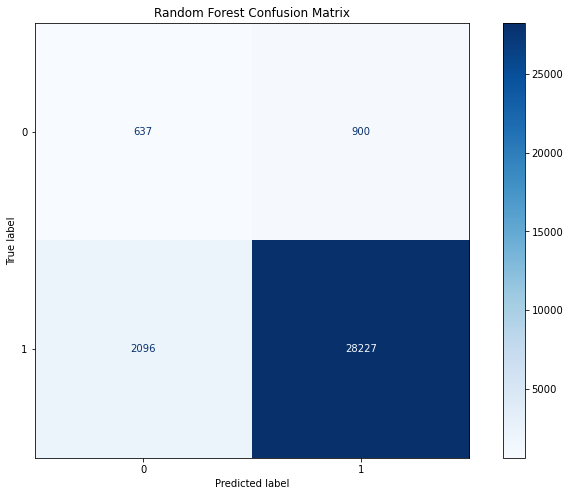

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
plot_confusion_matrix(rfc, _X_test_merged, y_test, cmap = 'Blues', values_format='d' , ax= ax)
ax.set_title('Random Forest Confusion Matrix')
fig.savefig('Random_Forest_Confusion_Matrix');

### LGBM Classifier

In [37]:
lgbm_clf = LGBMClassifier(objective='binary',
                     boosting='dart',
                     learning_rate = 0.010057081713819383,
                     max_depth = 7,
                     num_leaves = 78,
                     n_estimators = 400,
                     bagging_fraction = 0.16278353936317094,
                     feature_fraction = 0.3617006743319948,
                    colsample_bytree = 0.16703063631915752)

lgbm_clf.fit(_X_train_merged, y_train)
y_train_pred = lgbm_clf.predict(_X_train_merged)
y_test_pred = lgbm_clf.predict(_X_test_merged)



print('Training Precision: ', precision_score(y_train, y_train_pred))
print('Testing Precision: ', precision_score(y_test, y_test_pred))
print('\n\n')
print('Training F1-Score: ', f1_score(y_train, y_train_pred))
print('Testing F1-Score: ', f1_score(y_test, y_test_pred))

Training Precision:  0.9483085410637829
Testing Precision:  0.9699520474695553



Training F1-Score:  0.9371474920457064
Testing F1-Score:  0.9481031866464341


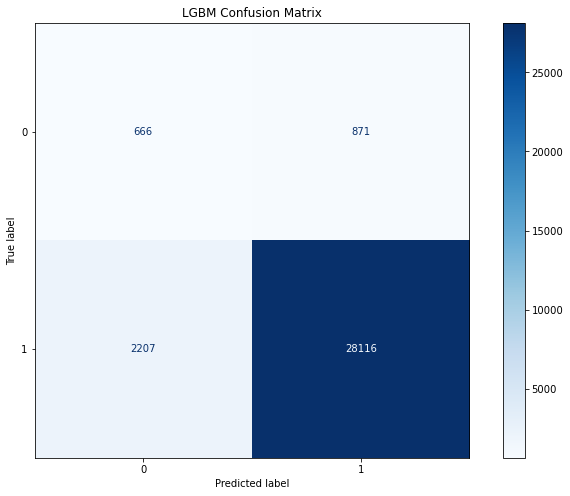

In [59]:
fig, ax = plt.subplots(figsize=(12,8))
plot_confusion_matrix(lgbm_clf, _X_test_merged, y_test, cmap = 'Blues', values_format='d' , ax= ax)
ax.set_title('LGBM Confusion Matrix')
fig.savefig('LGBM_Confusion_Matrix');

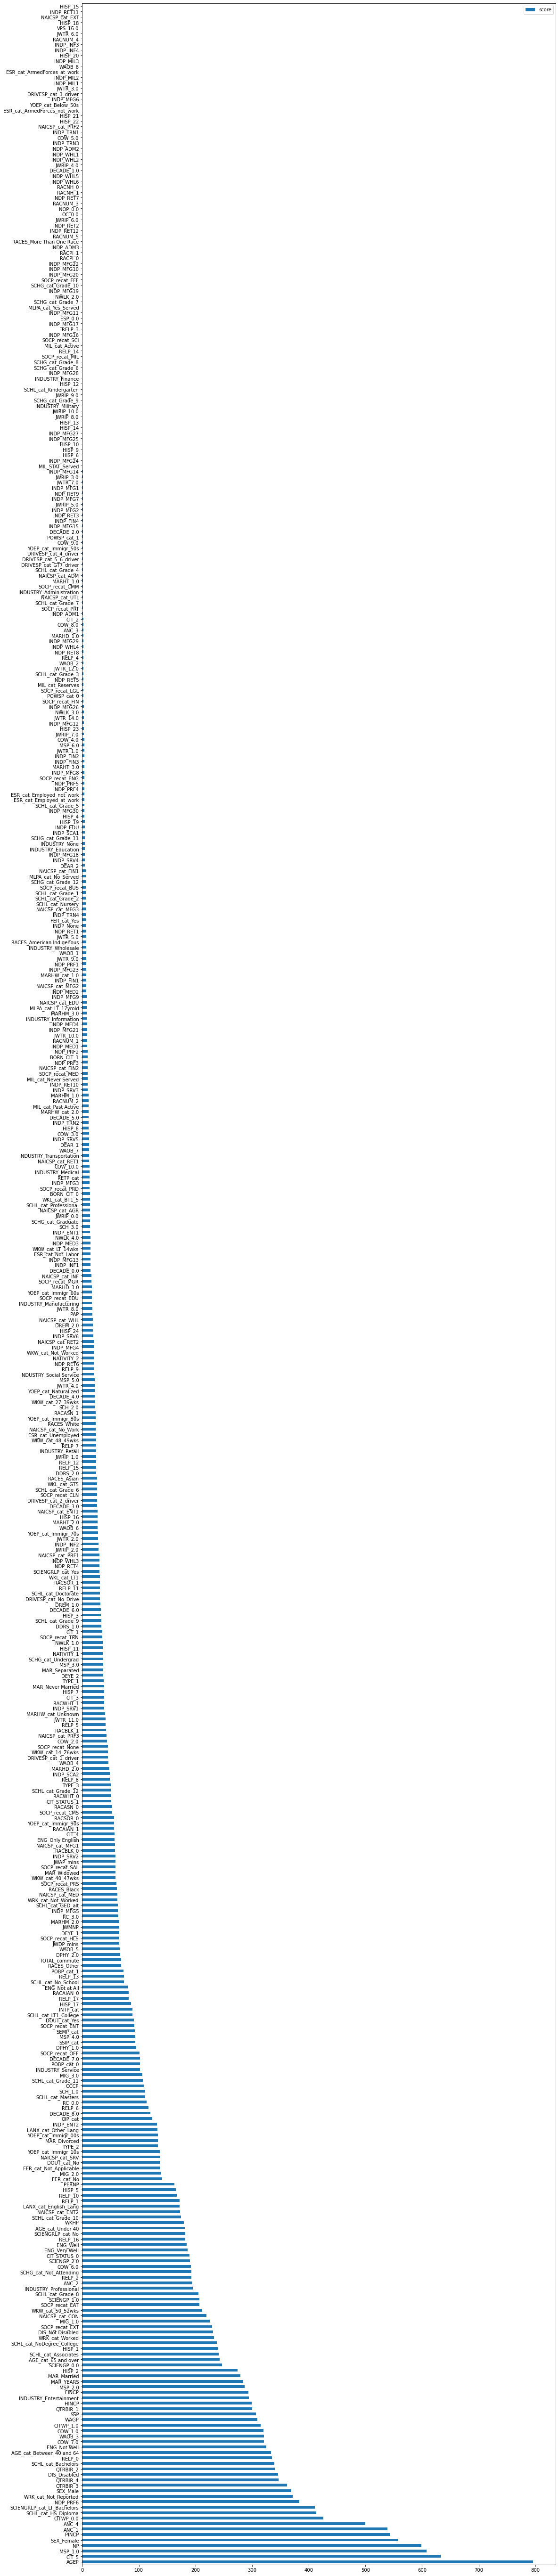

In [40]:
plot_features = pd.DataFrame(data = lgbm_clf.feature_importances_, index=_X_train_merged.columns, columns = ['score']).sort_values(by='score', ascending=False)
plot_features.plot(kind='barh', figsize=(18,100));


### Refit on entire Dataset

In [6]:
_X = X.copy()
_y = y.copy()

In [7]:
ohe_final = OneHotEncoder()
_X_final_ohe = ohe_final.fit_transform(_X[categorical_columns]).toarray()
_X_final_ohe_df = pd.DataFrame(data = _X_final_ohe,
                        columns = ohe_final.get_feature_names(categorical_columns))

In [50]:
with open('ohe_final.pickle', 'wb') as f:
    pickle.dump(ohe_final, f)

In [8]:
from sklearn.preprocessing import StandardScaler
scaler_final = StandardScaler()
_X_final_cont = scaler_final.fit_transform(_X[continuous_columns])
_X_final_cont_df = pd.DataFrame(data = _X_final_cont,
                         columns = continuous_columns)


In [52]:
with open('scaler_final.pickle', 'wb') as f:
    pickle.dump(scaler_final, f)

In [9]:
_X_final_merged = _X_final_cont_df[continuous_columns].merge(_X_final_ohe_df, left_index=True, right_index=True)
_X_final_merged.shape

(159299, 468)

In [54]:
from imblearn.over_sampling import SMOTE
_smote_final = SMOTE(sampling_strategy='minority', random_state=42)
_X_final_merged_SMOTE, _y_SMOTE = _smote_final.fit_sample(_X_final_merged, _y)

In [55]:

logreg_final =LogisticRegression(solver='liblinear', penalty='l1')


logreg_final.fit(_X_final_merged_SMOTE, _y_SMOTE)
y_final_pred_SMOTE = logreg_final.predict(_X_final_merged_SMOTE)
y_final_pred_standard = logreg_final.predict(_X_final_merged)


print('SMOTE Precision: ', precision_score(_y_SMOTE, y_final_pred_SMOTE))
print('Final-noSMOTE Precision: ', precision_score(_y, y_final_pred_standard))
print('\n\n')
print('SMOTE F1-Score: ', f1_score(_y_SMOTE, y_final_pred_SMOTE))
print('Final-noSMOTE F1-Score: ', f1_score(_y, y_final_pred_standard))

SMOTE Precision:  0.8087023396269015
Final-noSMOTE Precision:  0.9849954883341211



SMOTE F1-Score:  0.7822434243751961
Final-noSMOTE F1-Score:  0.8563722285522162


In [56]:
import pickle
with open('logreg_classifier.pickle', 'wb') as f:
    pickle.dump(logreg_final, f)

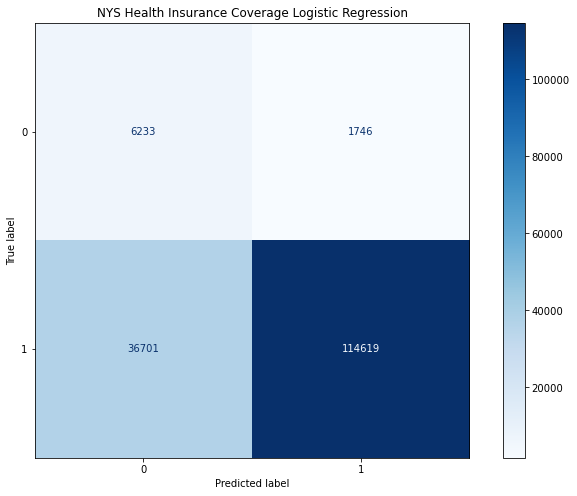

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
plot_confusion_matrix(logreg_final, _X_final_merged, _y, cmap = 'Blues', values_format='d' , ax= ax)
ax.set_title('NYS Health Insurance Coverage Logistic Regression')
fig.savefig('LogReg_Final_Confusion_Matrix');

In [5]:
with open('logreg_classifier.pickle', 'rb') as file:
    logreg_final = pickle.load(file)